[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1979
[LightGBM] [Info] Number of data points in the train set: 329, number of used features: 25
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

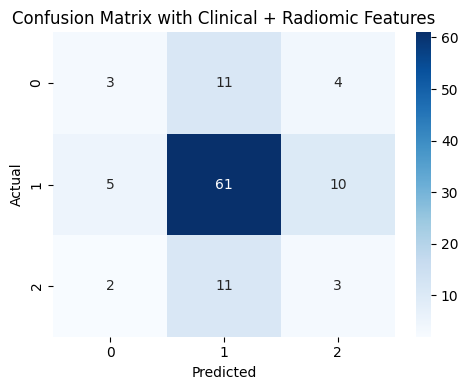

 94%|=================== | 311/330 [00:14<00:00]       

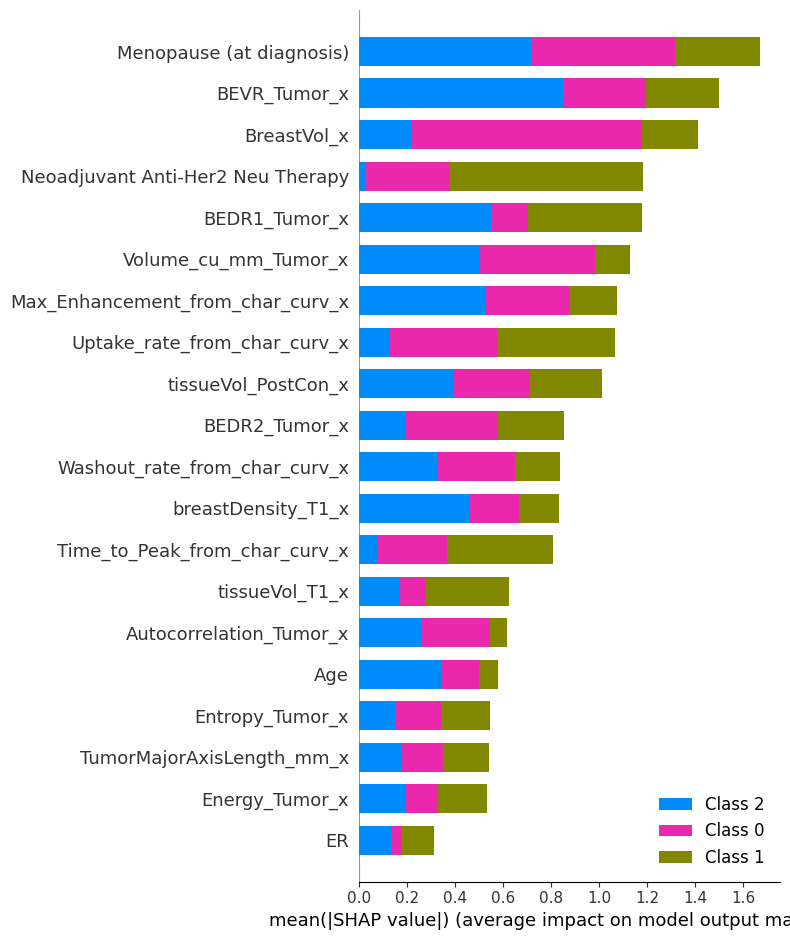

In [9]:
# Author: Lakshita Mahajan

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import QuantileTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings("ignore")

#  Load primary enriched dataset
df = pd.read_csv("../data/processed/cleaned_clinical_enriched.csv")
df["Patient_ID_Num"] = df["Patient ID"].astype(str).str.extract(r"(\d+)$").astype(int)

# Bring in additional clinical variables from the raw Excel sheet
df_clinical_raw = pd.read_excel("../Data/raw/Clinical_and_Other_Features.xlsx", sheet_name="Data")
df_clinical_raw.columns = df_clinical_raw.iloc[0]
df_clinical_raw = df_clinical_raw[2:]
df_clinical_raw["Patient_ID"] = df_clinical_raw["Patient ID"]
df_clinical_raw["Patient_ID_Num"] = df_clinical_raw["Patient_ID"].astype(str).str.extract(r"(\d+)$").astype(float).astype(int)

# Select important clinical variables of interest
columns_to_extract = [
    "Menopause (at diagnosis)", "ER", "PR", "HER2",
    "Neoadjuvant Chemotherapy", "Neoadjuvant Endocrine Therapy Medications ",
    "Adjuvant Endocrine Therapy Medications ", "Neoadjuvant Anti-Her2 Neu Therapy",
    "Adjuvant Anti-Her2 Neu Therapy ", "Received Neoadjuvant Therapy or Not"
]

# Merge the additional features into the main dataframe
df_clinical_add = df_clinical_raw[["Patient_ID_Num"] + columns_to_extract]
df = df.merge(df_clinical_add, on="Patient_ID_Num", how="left")

# Convert clinical features to numeric where possible (Y/N, status values)
for col in columns_to_extract:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute missing clinical values with -1 to indicate "unknown"
df[columns_to_extract] = df[columns_to_extract].fillna(-1)

# Define feature columns from radiomics + additional clinical features
radiomic_features = [
    'Age', 'breastDensity_T1_x', 'tissueVol_T1_x', 'tissueVol_PostCon_x', 'BreastVol_x',
    'TumorMajorAxisLength_mm_x', 'Volume_cu_mm_Tumor_x', 'Autocorrelation_Tumor_x',
    'Entropy_Tumor_x', 'Energy_Tumor_x', 'BEVR_Tumor_x', 'BEDR1_Tumor_x', 'BEDR2_Tumor_x',
    'Max_Enhancement_from_char_curv_x', 'Time_to_Peak_from_char_curv_x',
    'Uptake_rate_from_char_curv_x', 'Washout_rate_from_char_curv_x', 'Log_Tumor_Volume'
]
radiomic_features = [col for col in radiomic_features if col in df.columns]
all_features = radiomic_features + columns_to_extract

# Separate features and target variable
X = df[all_features]
y = df["Tumor_Response_Encoded"]

# Split data into train and test sets (stratified by label)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, stratify=y, random_state=42
)

# Apply quantile transformation for normalization
qt = QuantileTransformer(output_distribution='normal', random_state=42)
X_train_scaled = qt.fit_transform(X_train)
X_test_scaled = qt.transform(X_test)

# Convert scaled arrays back into DataFrames for clarity
X_train_df = pd.DataFrame(X_train_scaled, columns=all_features)
X_test_df = pd.DataFrame(X_test_scaled, columns=all_features)

# Address class imbalance using ADASYN oversampling
adasyn = ADASYN(random_state=42)
X_train_bal, y_train_bal = adasyn.fit_resample(X_train_df, y_train)

# Initialize LightGBM model with tuned hyperparameters
lgbm = LGBMClassifier(
    n_estimators=800,
    learning_rate=0.02,
    max_depth=6,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    class_weight='balanced',
    random_state=42
)

# Perform 5-fold cross-validation on the balanced training data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc, cv_f1 = [], []

for train_idx, val_idx in cv.split(X_train_bal, y_train_bal):
    X_tr, X_val = X_train_bal.iloc[train_idx], X_train_bal.iloc[val_idx]
    y_tr, y_val = y_train_bal.iloc[train_idx], y_train_bal.iloc[val_idx]
    lgbm.fit(X_tr, y_tr)
    preds = lgbm.predict(X_val)
    cv_acc.append(accuracy_score(y_val, preds))
    cv_f1.append(f1_score(y_val, preds, average='macro'))

print(f"\nCross-Validation Accuracy: {np.mean(cv_acc):.4f} ± {np.std(cv_acc):.4f}")
print(f"Cross-Validation Macro F1: {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")

# Retrain on full training data and evaluate on test set
lgbm.fit(X_train_bal, y_train_bal)
y_pred = lgbm.predict(X_test_df)

print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Macro F1: {f1_score(y_test, y_pred, average='macro'):.4f}")
print(classification_report(y_test, y_pred, digits=4))

# Visualize performance using confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix with Clinical + Radiomic Features')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Use SHAP to interpret feature contributions in model predictions
explainer = shap.Explainer(lgbm, X_train_bal)
shap_values = explainer(X_test_df)
shap.summary_plot(shap_values, X_test_df, feature_names=all_features)



Evaluating performance by 'Menopause (at diagnosis)':
  0: N=59, Accuracy=0.593, Macro F1=0.431
  1: N=51, Accuracy=0.627, Macro F1=0.348

Evaluating performance by 'Age_Group':
  <40: N=110, Accuracy=0.609, Macro F1=0.388
  Skipping group '40-49' (only 0 samples)
  Skipping group '50-59' (only 0 samples)
  Skipping group '60-69' (only 0 samples)
  Skipping group '70+' (only 0 samples)

Group-wise Performance Summary:
            Group Parameter Group    N  Accuracy  Macro F1
0                 Age_Group   <40  110  0.609091  0.387800
1  Menopause (at diagnosis)     0   59  0.593220  0.431227
2  Menopause (at diagnosis)     1   51  0.627451  0.348291


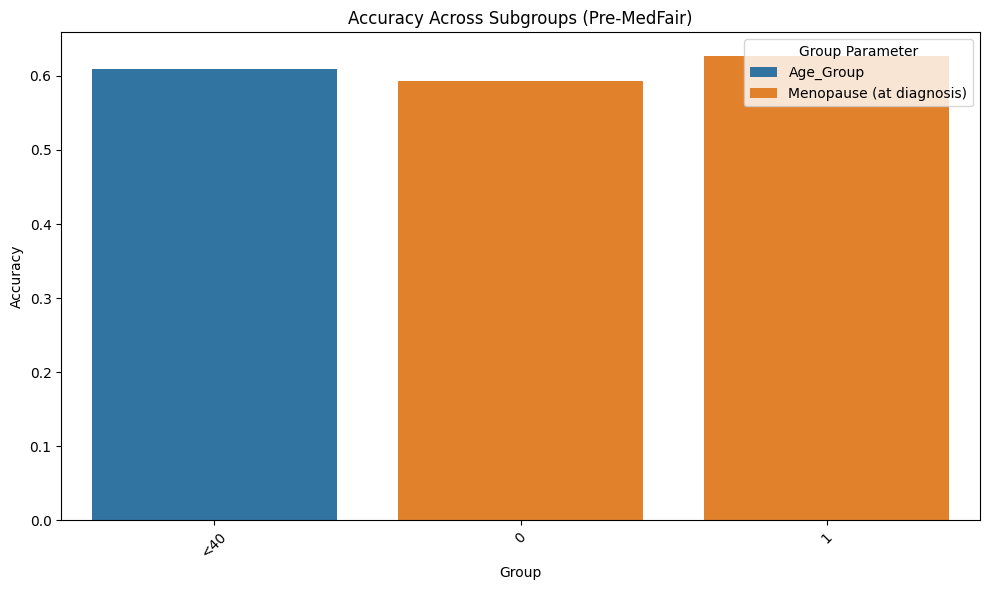

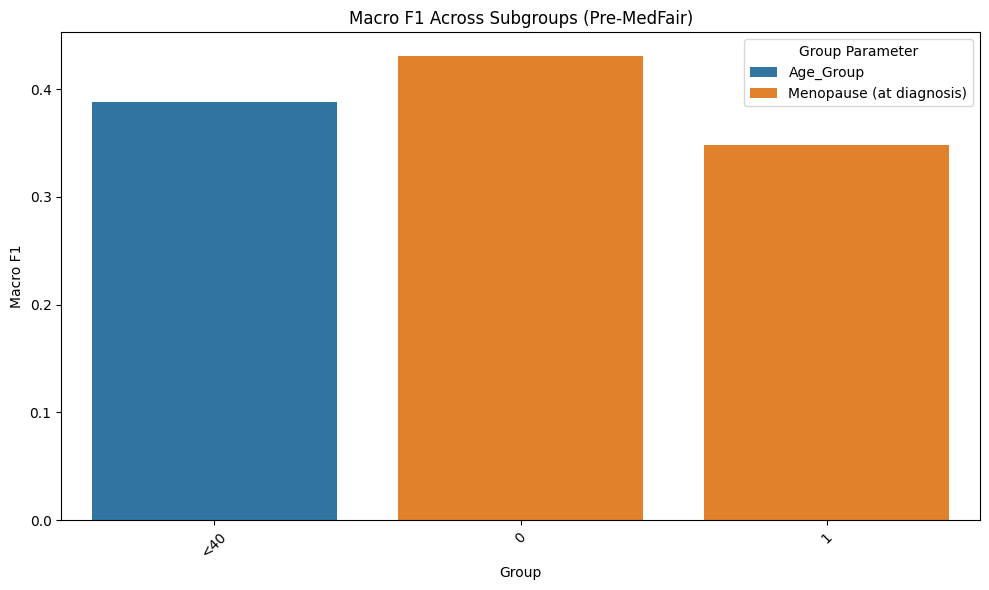

In [10]:
# Define the sensitive group attributes available in the dataset
group_columns = [
    "Race",  
    "Menopause (at diagnosis)",
    "Manufacturer",  
    "Model",         
    "Field Strength",
]

# Create age bins for grouped fairness analysis
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 40, 50, 60, 70, 120], labels=['<40', '40-49', '50-59', '60-69', '70+'])
group_columns.append('Age_Group')

# Initialize a list to collect group-level performance metrics
results = []

# Copy relevant test set values into a new DataFrame for subgroup evaluation
X_test_df["Tumor_Response_Encoded"] = y_test.values
X_test_df["Predicted"] = y_pred
X_test_df["Patient_ID_Num"] = df.loc[X_test.index, "Patient_ID_Num"].values

# Add group column values to test DataFrame for analysis
for col in group_columns:
    if col in df.columns:
        X_test_df[col] = df.loc[X_test.index, col].values
    else:
        print(f"Warning: '{col}' not found in dataset; skipping.")

# Loop through each group column and compute accuracy and macro F1 for each subgroup
for col in group_columns:
    if col not in X_test_df.columns:
        continue
    print(f"\nEvaluating performance by '{col}':")
    for group_name, group_df in X_test_df.groupby(col):
        if group_df.shape[0] < 5:
            print(f"  Skipping group '{group_name}' (only {group_df.shape[0]} samples)")
            continue
        acc = accuracy_score(group_df["Tumor_Response_Encoded"], group_df["Predicted"])
        f1 = f1_score(group_df["Tumor_Response_Encoded"], group_df["Predicted"], average='macro')
        results.append({
            "Group Parameter": col,
            "Group": group_name,
            "N": group_df.shape[0],
            "Accuracy": acc,
            "Macro F1": f1
        })
        print(f"  {group_name}: N={group_df.shape[0]}, Accuracy={acc:.3f}, Macro F1={f1:.3f}")

# Convert results to DataFrame for display and further processing
results_df = pd.DataFrame(results).sort_values(by=["Group Parameter", "Group"]).reset_index(drop=True)

print("\nGroup-wise Performance Summary:")
print(results_df)

# Save metrics to CSV for MedFair or future plotting
results_df.to_csv("../results/group_performance_pre_medfair.csv", index=False)

# Plot Accuracy across all subgroups
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x="Group", y="Accuracy", hue="Group Parameter")
plt.xticks(rotation=45)
plt.title("Accuracy Across Subgroups (Pre-MedFair)")
plt.tight_layout()
plt.show()

# Plot Macro F1-score across all subgroups
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x="Group", y="Macro F1", hue="Group Parameter")
plt.xticks(rotation=45)
plt.title("Macro F1 Across Subgroups (Pre-MedFair)")
plt.tight_layout()
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1884
[LightGBM] [Info] Number of data points in the train set: 332, number of used features: 18
[LightGBM] [Info] Start training from score -1.051545
[LightGBM] [Info] Start training from score -1.104655
[LightGBM] [Info] Start training from score -1.141696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

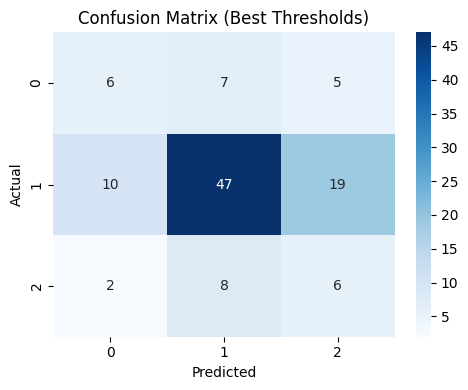

 97%|=================== | 320/330 [00:14<00:00]       

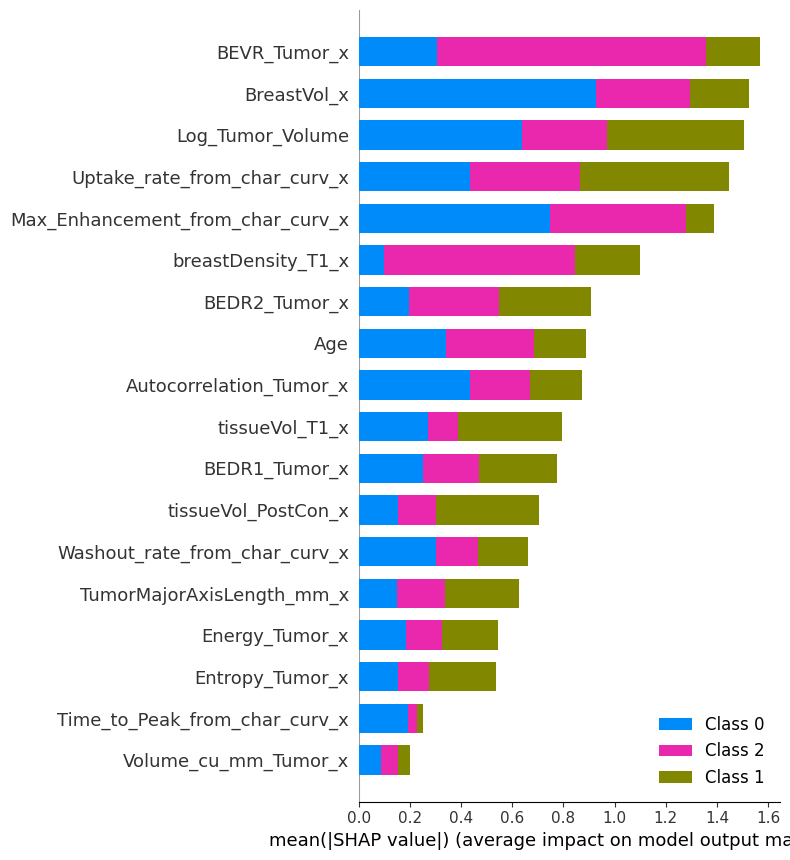


Fairness Evaluation by Race
   Group   N       Acc  F1_macro  ROC_AUC_OVO
0      1  67  0.522388  0.422969     0.579167
1      2  36  0.527778  0.359070     0.519907
2      5   2  0.500000  0.333333     0.500000
3      4   1  1.000000  1.000000          NaN
4      3   2  0.500000  0.333333          NaN
5      0   1  1.000000  1.000000          NaN
6      6   1  1.000000  1.000000          NaN

Fairness Evaluation by Menopausal_Status
   Group   N       Acc  F1_macro  ROC_AUC_OVO
0      0  59  0.542373  0.466369     0.616594
1      1  51  0.529412  0.356522     0.520990

Fairness Evaluation by Manufacturer
   Group   N       Acc  F1_macro  ROC_AUC_OVO
0      2  43  0.627907  0.530094     0.672414
1      0  67  0.477612  0.353923     0.517354

Fairness Evaluation by Manufacturer_Model
   Group   N       Acc  F1_macro  ROC_AUC_OVO
0      0  26  0.615385  0.517460     0.694444
1      4  25  0.400000  0.312698     0.500980
2      7  10  0.700000  0.433333          NaN
3      3  35  0.57142

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from lightgbm import LGBMClassifier
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
import warnings
warnings.filterwarnings("ignore")

# Load processed dataset with radiomic and clinical variables
df = pd.read_csv("../data/processed/cleaned_clinical_enriched.csv")
df["Patient_ID_Num"] = df["Patient ID"].astype(str).str.extract(r"(\d+)$").astype(int)

# Define selected high-impact radiomic and imaging-based features
feature_columns = [
    "Age", "breastDensity_T1_x", "BreastVol_x", "tissueVol_T1_x", "tissueVol_PostCon_x",
    "Log_Tumor_Volume", "TumorMajorAxisLength_mm_x", "Volume_cu_mm_Tumor_x",
    "Autocorrelation_Tumor_x", "Entropy_Tumor_x", "Energy_Tumor_x",
    "BEVR_Tumor_x", "BEDR1_Tumor_x", "BEDR2_Tumor_x",
    "Max_Enhancement_from_char_curv_x", "Time_to_Peak_from_char_curv_x",
    "Uptake_rate_from_char_curv_x", "Washout_rate_from_char_curv_x"
]
feature_columns = [col for col in feature_columns if col in df.columns]

# Extract features and labels
X = df[feature_columns]
y = df["Tumor_Response_Encoded"]

# Split data into training and test sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)

# Apply quantile transformation to normalize feature distributions
qt = QuantileTransformer(output_distribution='normal', random_state=42)
X_train_scaled = qt.fit_transform(X_train)
X_test_scaled = qt.transform(X_test)
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_columns)

# Balance class distribution using ADASYN
adasyn = ADASYN(random_state=42)
X_train_bal, y_train_bal = adasyn.fit_resample(X_train_df, y_train)

# Initialize LightGBM classifier
lgbm = LGBMClassifier(
    n_estimators=800, learning_rate=0.02, max_depth=6, num_leaves=31,
    subsample=0.9, colsample_bytree=0.9, random_state=42
)

# Perform 5-fold cross-validation on the balanced data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc, cv_f1 = [], []

for train_idx, val_idx in cv.split(X_train_bal, y_train_bal):
    lgbm.fit(X_train_bal.iloc[train_idx], y_train_bal.iloc[train_idx])
    preds = lgbm.predict(X_train_bal.iloc[val_idx])
    cv_acc.append(accuracy_score(y_train_bal.iloc[val_idx], preds))
    cv_f1.append(f1_score(y_train_bal.iloc[val_idx], preds, average='macro'))

print(f"\nCross-Validation Accuracy: {np.mean(cv_acc):.4f} ± {np.std(cv_acc):.4f}")
print(f"Cross-Validation Macro F1: {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")

# Grid search for best probability threshold set
threshold_grid = [[0.15, 0.7, 0.15], [0.20, 0.6, 0.20], [0.25, 0.5, 0.25]]
best = {"accuracy": 0, "macro_f1": 0, "thresholds": None}

for t in threshold_grid:
    y_probs = lgbm.predict_proba(X_test_df)
    y_pred = [0 if p[0] > t[0] else 2 if p[2] > t[2] else 1 for p in y_probs]
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average='macro')
    print(f"Thresholds {t}: Accuracy = {acc:.4f}, Macro F1 = {f1m:.4f}")
    if acc > best['accuracy']:
        best.update({"accuracy": acc, "macro_f1": f1m, "thresholds": t})

print(f"\nBest Thresholds: {best}")

# Generate final predictions using best thresholds
y_probs = lgbm.predict_proba(X_test_df)
y_pred = [0 if p[0] > best['thresholds'][0] else 2 if p[2] > best['thresholds'][2] else 1 for p in y_probs]

# Display confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Best Thresholds)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# SHAP interpretability to analyze feature contributions
explainer = shap.Explainer(lgbm, X_train_bal)
shap_values = explainer(X_test_df)
shap.summary_plot(shap_values, X_test_df, feature_names=feature_columns)

# Prepare predictions DataFrame for fairness analysis
df_preds = pd.DataFrame({
    "Patient_ID_Num": df.loc[X_test.index, "Patient_ID_Num"].values,
    "True_Label": y_test.values,
    "Pred_LGBM_Tuned": y_pred
})

# Select sensitive attributes for subgroup evaluation
df_sensitive = df[["Patient_ID_Num", "Age"]]
for col in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 5", "Unnamed: 20", "Unnamed: 21"]:
    if col in df.columns:
        df_sensitive[col] = df[col]

# Rename columns for clarity
df_sensitive = df_sensitive.rename(columns={
    "Unnamed: 2": "Manufacturer",
    "Unnamed: 3": "Manufacturer_Model",
    "Unnamed: 5": "Field_Strength",
    "Unnamed: 20": "Menopausal_Status",
    "Unnamed: 21": "Race"
})

# Bin ages into groups
df_sensitive["Age_Years"] = df_sensitive["Age"] * 10
df_sensitive["Age_Group"] = pd.cut(df_sensitive["Age_Years"], [0, 49, 64, 150], labels=["Young", "Middle", "Older"])

# Merge predictions and sensitive attributes
df_eval = df_preds.merge(df_sensitive, on="Patient_ID_Num").dropna()
os.makedirs("../results_lgbm_tuned/", exist_ok=True)

# Define function to compute subgroup performance metrics
def metrics(df, col):
    out = []
    for g in df[col].dropna().unique():
        sub = df[df[col] == g]
        acc = accuracy_score(sub["True_Label"], sub["Pred_LGBM_Tuned"])
        f1 = f1_score(sub["True_Label"], sub["Pred_LGBM_Tuned"], average='macro')
        try:
            roc = roc_auc_score(sub["True_Label"], pd.get_dummies(sub["Pred_LGBM_Tuned"]), multi_class='ovo')
        except:
            roc = np.nan
        out.append({
            "Group": g,
            "N": len(sub),
            "Acc": acc,
            "F1_macro": f1,
            "ROC_AUC_OVO": roc
        })
    return pd.DataFrame(out)

# Compute and save fairness metrics for each sensitive attribute
for dim in ["Race", "Menopausal_Status", "Manufacturer", "Manufacturer_Model", "Field_Strength", "Age_Group"]:
    if dim in df_eval.columns:
        m = metrics(df_eval, dim)
        print(f"\nFairness Evaluation by {dim}")
        print(m)
        m.to_csv(f"../results_lgbm_tuned/metrics_{dim}.csv", index=False)
